In [1]:
import os
import random
from itertools import combinations

import editdistance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import Dataset, load_dataset
from llms.dna_translator.gpt import DNATranslatorGPT
from pandas import DataFrame
from schemas.train_params import TrainParams
from tqdm import tqdm

# Limits

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [3]:
SEED = 42

# Minimal Dataset

In [4]:
dataset = load_dataset("GustavoHCruz/DNA_Coding_Regions", split="train")

assert isinstance(dataset, Dataset)

dataset = dataset.to_pandas()

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

In [5]:
def join_proteins(protein_list) -> str:
	seqs = []
	for p in protein_list:
		seq = p.get("sequence", "")
		if isinstance(seq, str):
			seqs.append(seq)
	return "".join(seqs)

In [6]:
assert isinstance(dataset, DataFrame)

dataset["target"] = dataset["proteins"].apply(join_proteins).astype(str)
mask = (dataset["sequence"].str.len() + dataset["target"].str.len()) < 1000
original_df = dataset[mask]
original_df = original_df[["sequence", "target", "organism"]]

In [7]:
print("Final Length of Dataset: ", len(original_df))

Final Length of Dataset:  244090


# How Many Trivial?

In [8]:
CODON_TABLE = {
	'TTT':'F','TTC':'F','TTA':'L','TTG':'L',
	'CTT':'L','CTC':'L','CTA':'L','CTG':'L',
	'ATT':'I','ATC':'I','ATA':'I','ATG':'M',
	'GTT':'V','GTC':'V','GTA':'V','GTG':'V',
	'TCT':'S','TCC':'S','TCA':'S','TCG':'S',
	'CCT':'P','CCC':'P','CCA':'P','CCG':'P',
	'ACT':'T','ACC':'T','ACA':'T','ACG':'T',
	'GCT':'A','GCC':'A','GCA':'A','GCG':'A',
	'TAT':'Y','TAC':'Y','TAA':'*','TAG':'*',
	'CAT':'H','CAC':'H','CAA':'Q','CAG':'Q',
	'AAT':'N','AAC':'N','AAA':'K','AAG':'K',
	'GAT':'D','GAC':'D','GAA':'E','GAG':'E',
	'TGT':'C','TGC':'C','TGA':'*','TGG':'W',
	'CGT':'R','CGC':'R','CGA':'R','CGG':'R',
	'AGT':'S','AGC':'S','AGA':'R','AGG':'R',
	'GGT':'G','GGC':'G','GGA':'G','GGG':'G'
}

def translate_frame(seq, frame):
	protein = []
	for i in range(frame, len(seq) - 2, 3):
		codon = seq[i:i+3]
		protein.append(CODON_TABLE.get(codon, 'X'))
	return ''.join(protein)

def protein_segments(protein):
	return [seg for seg in protein.split('*') if len(seg) > 0]

def similarity(a, b):
	if len(a) == 0 or len(b) == 0:
		return 0.0
	dist = editdistance.eval(a, b)
	return 1.0 - dist / max(len(a), len(b))

In [9]:
TRIVIAL_THRESHOLD = 0.8
AMBIGUOUS_THRESHOLD = 0.65

In [10]:
max_similarities = []

for _, row in tqdm(original_df.iterrows(), total=len(original_df)):
	dna = row["sequence"].upper()
	target = row["target"]

	best = 0.0

	for frame in (0, 1, 2):
		protein = translate_frame(dna, frame)
		segments = protein_segments(protein)

		for seg in segments:
			sim = similarity(seg, target)
			if sim > best:
				best = sim

	max_similarities.append(best)

original_df["max_frame_similarity"] = max_similarities

100%|██████████| 244090/244090 [00:41<00:00, 5946.73it/s]


In [11]:
def classify(sim):
	if sim >= TRIVIAL_THRESHOLD:
		return "trivial"
	elif sim >= AMBIGUOUS_THRESHOLD:
		return "ambiguous"
	else:
		return "genomic"

original_df["translation_class"] = original_df["max_frame_similarity"].apply(classify)

In [12]:
print("Distribution:")
print(original_df["translation_class"].value_counts())

Distribution:
translation_class
genomic      154191
trivial       60266
ambiguous     29633
Name: count, dtype: int64


In [13]:
print("Percentils:")
print(original_df["translation_class"].value_counts(normalize=True) * 100)

Percentils:
translation_class
genomic      63.169732
trivial      24.690073
ambiguous    12.140194
Name: proportion, dtype: float64


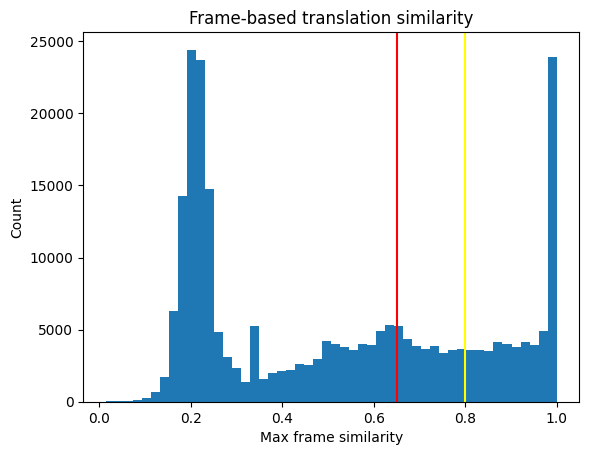

In [14]:
plt.figure()
plt.hist(original_df["max_frame_similarity"], bins=50)
plt.axvline(TRIVIAL_THRESHOLD, color="yellow")
plt.axvline(AMBIGUOUS_THRESHOLD, color="red")
plt.xlabel("Max frame similarity")
plt.ylabel("Count")
plt.title("Frame-based translation similarity")
plt.show()

In [15]:
genomic = original_df[original_df["translation_class"] == "genomic"]
ambiguous = original_df[original_df["translation_class"] == "ambiguous"]
trivial = original_df[original_df["translation_class"] == "trivial"]

In [16]:
print(f"Genomics: {len(genomic)} ({len(genomic)/len(original_df)*100:.2f}%)")
print(f"Other (trivial + ambiguous): {len(ambiguous) + len(trivial)} ({(len(ambiguous) + len(trivial))/len(original_df)*100:.2f}%)")

Genomics: 154191 (63.17%)
Other (trivial + ambiguous): 89899 (36.83%)


# Data Structure & Analysis

In [17]:
stats = genomic.copy()

stats["organism_norm"] = (
	stats["organism"]
	.astype(str)
	.str.strip()
	.str.lower()
)

print(f"Total of Sequences: {len(stats)}")
print(f"Total of Species: {stats['organism_norm'].nunique()}")

Total of Sequences: 154191
Total of Species: 10491


In [18]:
species_stats = (
	stats
	.groupby("organism_norm")
	.agg(
		num_sequences=("sequence", "count"),
		avg_seq_length=("sequence", lambda x: x.str.len().mean())
	)
	.reset_index()
)

In [19]:
print("Number of sequences per species:")
print(species_stats["num_sequences"].describe())

Number of sequences per species:
count    10491.000000
mean        14.697455
std        332.340777
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      25633.000000
Name: num_sequences, dtype: float64


In [20]:
print("Average sequence size by species:")
print(species_stats["avg_seq_length"].describe())

Average sequence size by species:
count    10491.000000
mean       664.181832
std        200.332992
min         80.000000
25%        521.000000
50%        682.000000
75%        852.000000
max        996.000000
Name: avg_seq_length, dtype: float64


In [21]:
print("Species with MORE sequences:")
print(species_stats.loc[species_stats["num_sequences"].idxmax()])

Species with MORE sequences:
organism_norm     rotaria magnacalcarata
num_sequences                      25633
avg_seq_length                459.185581
Name: 8592, dtype: object


In [22]:
print("Species with FEWER sequences:")
print(species_stats.loc[species_stats["num_sequences"].idxmin()])

Species with FEWER sequences:
organism_norm     [ballota] hirsuta subsp. intermedia
num_sequences                                       1
avg_seq_length                                  851.0
Name: 0, dtype: object


# Similarity Check

In [23]:
MAX_PAIRS_PER_SPECIES = 500
MAX_INTERSPECIES_PAIRS = 50000

In [24]:
random.seed(SEED)

In [25]:
def dna_similarity(a, b):
	if len(a) == 0 or len(b) == 0:
		return 0.0
	dist = editdistance.eval(a, b)
	return 1.0 - dist / max(len(a), len(b))

In [26]:
intra_results = []

for organism, group in tqdm(genomic.groupby("organism"), desc="Intra-species"):
	sequences = group["sequence"].tolist()

	if len(sequences) < 2:
		continue

	pairs = list(combinations(sequences, 2))
	random.shuffle(pairs)
	pairs = pairs[:MAX_PAIRS_PER_SPECIES]

	for a, b in pairs:
		sim = dna_similarity(a, b)
		intra_results.append({
			"organism": organism,
			"similarity": sim
		})

Intra-species: 100%|██████████| 10491/10491 [07:46<00:00, 22.47it/s] 


In [27]:
intra_df = pd.DataFrame(intra_results)

print("INTRA-SPECIES")
print(intra_df["similarity"].describe())

INTRA-SPECIES
count    144999.000000
mean          0.710914
std           0.255095
min           0.037554
25%           0.477306
50%           0.714083
75%           0.982895
max           0.998996
Name: similarity, dtype: float64


In [ ]:
organisms = genomic["organism"].unique().tolist()
inter_results = []

pairs_done = 0

for org_a, org_b in tqdm(list(combinations(organisms, 2)), desc="Inter-species"):
	if pairs_done >= MAX_INTERSPECIES_PAIRS:
		break

	seqs_a = genomic[genomic["organism"] == org_a]["sequence"].tolist()
	seqs_b = genomic[genomic["organism"] == org_b]["sequence"].tolist()

	if not seqs_a or not seqs_b:
		continue

	a = random.choice(seqs_a)
	b = random.choice(seqs_b)

	sim = dna_similarity(a, b)
	inter_results.append({
		"organism_a": org_a,
		"organism_b": org_b,
		"similarity": sim
	})

	pairs_done += 1

Inter-species:   0%|          | 3352/55025295 [00:39<196:37:31, 77.73it/s]

In [ ]:
inter_df = pd.DataFrame(inter_results)

print("INTER-SPECIES")
print(inter_df["similarity"].describe())

In [ ]:
plt.figure()
plt.hist(
	intra_df["similarity"],
	bins=50,
	alpha=0.6,
	label="Intra-species",
	density=True
)
plt.hist(
	inter_df["similarity"],
	bins=50,
	alpha=0.6,
	label="Inter-species",
	density=True
)

plt.xlabel("Genomic similarity")
plt.ylabel("Density")
plt.legend()
plt.title("Intra vs Inter species similarity distribution")
plt.show()


# Splitting Things

In [ ]:
def split_by_organism(
	df,
	seed=SEED,
	train_ratio=0.85,
	test_ratio=0.10,
	val_ratio=0.05
):
	assert abs(train_ratio + test_ratio + val_ratio - 1.0) < 1e-6

	random.seed(seed)
	np.random.seed(seed)

	organisms = df["organism"].unique().tolist()
	random.shuffle(organisms)

	n_orgs = len(organisms)

	n_train = int(n_orgs * train_ratio)
	n_test = int(n_orgs * test_ratio)

	train_orgs = set(organisms[:n_train])
	test_orgs = set(organisms[n_train:n_train + n_test])
	val_orgs = set(organisms[n_train + n_test:])

	train_df = df[df["organism"].isin(train_orgs)].reset_index(drop=True)
	test_df = df[df["organism"].isin(test_orgs)].reset_index(drop=True)
	val_df = df[df["organism"].isin(val_orgs)].reset_index(drop=True)

	print("=" * 60)
	print(f"Seed: {seed}")
	print(f"Total organisms: {n_orgs}")
	print()
	print("Organism split:")
	print(f"  Train: {len(train_orgs)} organisms")
	print(f"  Test : {len(test_orgs)} organisms")
	print(f"  Val  : {len(val_orgs)} organisms")
	print()
	print("Sequence split:")
	print(f"  Train: {len(train_df)} sequences")
	print(f"  Test : {len(test_df)} sequences")
	print(f"  Val  : {len(val_df)} sequences")
	print()
	print("Approximate ratios (by sequence):")
	total_seq = len(df)
	print(f"  Train: {len(train_df)/total_seq:.3f}")
	print(f"  Test : {len(test_df)/total_seq:.3f}")
	print(f"  Val  : {len(val_df)/total_seq:.3f}")
	print("=" * 60)

	return train_df, test_df, val_df

In [ ]:
train_df, test_df, val_df = split_by_organism(
	genomic,
	seed=SEED
)

# Training To Generate

In [ ]:
llm = DNATranslatorGPT(
  checkpoint="./storage/models/base/gpt2",
  seed=SEED
)

In [ ]:
train_data = train_df.to_dict(orient="records")
test_data = test_df.to_dict(orient="records")
val_data = val_df.to_dict(orient="records")

In [ ]:
train_dataset = []
for record in tqdm(train_data, desc="Train Data"):
	example = llm.build_input(
		dna_sequence=record["sequence"],
		organism=record["organism"],
		protein_sequence=record["target"]
	)
	train_dataset.append(example)

test_dataset = []
for record in tqdm(test_data, desc="Test Data"):
	example = llm.build_input(
		dna_sequence=record["sequence"],
		organism=record["organism"],
		protein_sequence=record["target"]
	)
	test_dataset.append(example)

eval_dataset = []
for record in tqdm(val_data, desc="Eval Data"):
	example = llm.build_input(
		dna_sequence=record["sequence"],
		organism=record["organism"],
		protein_sequence=record["target"]
	)
	eval_dataset.append(example)

In [ ]:
train_lengths = [len(example["dna_sequence"]) for example in train_dataset]
eval_lengths = [len(example["dna_sequence"]) for example in eval_dataset]
test_lengths = [len(example["dna_sequence"]) for example in test_dataset]

In [ ]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.histplot(train_lengths, kde=True, bins=40, color="skyblue", label="Train")
sns.histplot(eval_lengths, kde=True, bins=40, color="green", label="Eval")
sns.histplot(test_lengths, kde=True, bins=40, color="salmon", label="Test")

plt.title("Sequence Length Distribution", fontsize=16, weight="bold")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
llm.train(
  train_dataset=train_dataset,
  params=TrainParams(
    epochs=5,
    batch_size=4,
    gradient_accumulation=4,
    lr=3e-5
	),
  eval_dataset=eval_dataset
)

In [ ]:
llm.save_pretrained("GeneFormer-x1")

In [ ]:
results = []

for data in tqdm(test_dataset):
	pred = llm.generate(data)
	target = data["protein_sequence"]

	dist = editdistance.eval(pred, target)
	similarity = 1 - dist / max(len(pred), len(target))

	results.append({
		"target": target,
		"pred": pred,
		"edit_dist": dist,
		"similarity": similarity
	})

In [ ]:
similarities = [r["similarity"] for r in results]
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)

print(f"Mean similarity: {mean_similarity:.4f} ± {std_similarity:.4f}")

In [ ]:
llm.train(
  train_dataset=train_dataset,
  params=TrainParams(
    epochs=5,
    batch_size=4,
    gradient_accumulation=4,
    lr=3e-5
	),
  eval_dataset=eval_dataset
)

In [ ]:
llm.save_pretrained("GeneFormer-x2")

In [ ]:
results = []

for data in tqdm(test_dataset):
	pred = llm.generate(data)
	target = data["protein_sequence"]

	dist = editdistance.eval(pred, target)
	similarity = 1 - dist / max(len(pred), len(target))

	results.append({
		"target": target,
		"pred": pred,
		"edit_dist": dist,
		"similarity": similarity
	})

In [ ]:
similarities = [r["similarity"] for r in results]
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)

print(f"Mean similarity: {mean_similarity:.4f} ± {std_similarity:.4f}")

In [ ]:
llm.train(
  train_dataset=train_dataset,
  params=TrainParams(
    epochs=5,
    batch_size=4,
    gradient_accumulation=4,
    lr=3e-5
	),
  eval_dataset=eval_dataset
)

In [ ]:
llm.save_pretrained("GeneFormer-x3")

In [ ]:
results = []

for data in tqdm(test_dataset):
	pred = llm.generate(data)
	target = data["protein_sequence"]

	dist = editdistance.eval(pred, target)
	similarity = 1 - dist / max(len(pred), len(target))

	results.append({
		"target": target,
		"pred": pred,
		"edit_dist": dist,
		"similarity": similarity
	})

In [ ]:
similarities = [r["similarity"] for r in results]
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)

print(f"Mean similarity: {mean_similarity:.4f} ± {std_similarity:.4f}")

In [ ]:
pd.DataFrame(results).to_csv("prediction_results.csv")